In [1]:
from main import *

In [2]:

YEARS = [2018, 2019, 2021, 2022, 2023, 2024]
SAVE_DIR = "data"

fetch_lap_data(YEARS, save_dir=SAVE_DIR)
fetch_car_data(YEARS, save_dir=SAVE_DIR)



req         WARNING 	DEFAULT CACHE ENABLED! (659.66 MB) /Users/jigs/Library/Caches/fastf1
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info


Fetching lap data for Monaco 2018...


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '10', '27', '33', '55', '9', '11', '20', '2', '8', '35', '18', '16', '28', '14']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_

Saved lap data to data/monaco_laps_2018.csv
Fetching lap data for Monaco 2019...


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Saved lap data to data/monaco_laps_2019.csv
Fetching lap data for Monaco 2021...


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Saved lap data to data/monaco_laps_2021.csv
Fetching lap data for Monaco 2022...


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Saved lap data to data/monaco_laps_2022.csv
Fetching lap data for Monaco 2023...


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Saved lap data to data/monaco_laps_2023.csv
Fetching lap data for Monaco 2024...


req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Saved lap data to data/monaco_laps_2024.csv
Fetching car data for Monaco 2018...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '10', '27', '33', '55', '9', '11', '20', '2', '8', '35', '18', '16', '28', '14']


  Saved data/car_data_2018_driver_3.csv
  Saved data/car_data_2018_driver_5.csv
  Saved data/car_data_2018_driver_44.csv
  Saved data/car_data_2018_driver_7.csv
  Saved data/car_data_2018_driver_77.csv
  Saved data/car_data_2018_driver_31.csv
  Saved data/car_data_2018_driver_10.csv
  Saved data/car_data_2018_driver_27.csv
  Saved data/car_data_2018_driver_33.csv
  Saved data/car_data_2018_driver_55.csv
  Saved data/car_data_2018_driver_9.csv
  Saved data/car_data_2018_driver_11.csv
  Saved data/car_data_2018_driver_20.csv
  Saved data/car_data_2018_driver_2.csv
  Saved data/car_data_2018_driver_8.csv
  Saved data/car_data_2018_driver_35.csv
  Saved data/car_data_2018_driver_18.csv
  Saved data/car_data_2018_driver_16.csv


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved data/car_data_2018_driver_28.csv
  Saved data/car_data_2018_driver_14.csv
Fetching car data for Monaco 2019...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']


  Saved data/car_data_2019_driver_44.csv
  Saved data/car_data_2019_driver_5.csv
  Saved data/car_data_2019_driver_77.csv
  Saved data/car_data_2019_driver_33.csv
  Saved data/car_data_2019_driver_10.csv
  Saved data/car_data_2019_driver_55.csv
  Saved data/car_data_2019_driver_26.csv
  Saved data/car_data_2019_driver_23.csv
  Saved data/car_data_2019_driver_3.csv
  Saved data/car_data_2019_driver_8.csv
  Saved data/car_data_2019_driver_4.csv
  Saved data/car_data_2019_driver_11.csv
  Saved data/car_data_2019_driver_27.csv
  Saved data/car_data_2019_driver_20.csv
  Saved data/car_data_2019_driver_63.csv
  Saved data/car_data_2019_driver_18.csv
  Saved data/car_data_2019_driver_7.csv
  Saved data/car_data_2019_driver_88.csv


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved data/car_data_2019_driver_99.csv
  Saved data/car_data_2019_driver_16.csv
Fetching car data for Monaco 2021...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']


  Saved data/car_data_2021_driver_33.csv
  Saved data/car_data_2021_driver_55.csv
  Saved data/car_data_2021_driver_4.csv
  Saved data/car_data_2021_driver_11.csv
  Saved data/car_data_2021_driver_5.csv
  Saved data/car_data_2021_driver_10.csv
  Saved data/car_data_2021_driver_44.csv
  Saved data/car_data_2021_driver_18.csv
  Saved data/car_data_2021_driver_31.csv
  Saved data/car_data_2021_driver_99.csv
  Saved data/car_data_2021_driver_7.csv
  Saved data/car_data_2021_driver_3.csv
  Saved data/car_data_2021_driver_14.csv
  Saved data/car_data_2021_driver_63.csv
  Saved data/car_data_2021_driver_6.csv
  Saved data/car_data_2021_driver_22.csv
  Saved data/car_data_2021_driver_9.csv


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved data/car_data_2021_driver_47.csv
  Saved data/car_data_2021_driver_77.csv
  Saved data/car_data_2021_driver_16.csv
Fetching car data for Monaco 2022...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']


  Saved data/car_data_2022_driver_11.csv
  Saved data/car_data_2022_driver_55.csv
  Saved data/car_data_2022_driver_1.csv
  Saved data/car_data_2022_driver_16.csv
  Saved data/car_data_2022_driver_63.csv
  Saved data/car_data_2022_driver_4.csv
  Saved data/car_data_2022_driver_14.csv
  Saved data/car_data_2022_driver_44.csv
  Saved data/car_data_2022_driver_77.csv
  Saved data/car_data_2022_driver_5.csv
  Saved data/car_data_2022_driver_10.csv
  Saved data/car_data_2022_driver_31.csv
  Saved data/car_data_2022_driver_3.csv
  Saved data/car_data_2022_driver_18.csv
  Saved data/car_data_2022_driver_6.csv
  Saved data/car_data_2022_driver_24.csv
  Saved data/car_data_2022_driver_22.csv
  Saved data/car_data_2022_driver_23.csv


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved data/car_data_2022_driver_47.csv
  Saved data/car_data_2022_driver_20.csv
Fetching car data for Monaco 2023...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']


  Saved data/car_data_2023_driver_1.csv
  Saved data/car_data_2023_driver_14.csv
  Saved data/car_data_2023_driver_31.csv
  Saved data/car_data_2023_driver_44.csv
  Saved data/car_data_2023_driver_63.csv
  Saved data/car_data_2023_driver_16.csv
  Saved data/car_data_2023_driver_10.csv
  Saved data/car_data_2023_driver_55.csv
  Saved data/car_data_2023_driver_4.csv
  Saved data/car_data_2023_driver_81.csv
  Saved data/car_data_2023_driver_77.csv
  Saved data/car_data_2023_driver_21.csv
  Saved data/car_data_2023_driver_24.csv
  Saved data/car_data_2023_driver_23.csv
  Saved data/car_data_2023_driver_22.csv
  Saved data/car_data_2023_driver_11.csv
  Saved data/car_data_2023_driver_27.csv
  Saved data/car_data_2023_driver_2.csv
  Saved data/car_data_2023_driver_20.csv
  Saved data/car_data_2023_driver_18.csv
Fetching car data for Monaco 2024...


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


  Saved data/car_data_2024_driver_16.csv
  Saved data/car_data_2024_driver_81.csv
  Saved data/car_data_2024_driver_55.csv
  Saved data/car_data_2024_driver_4.csv
  Saved data/car_data_2024_driver_63.csv
  Saved data/car_data_2024_driver_1.csv
  Saved data/car_data_2024_driver_44.csv
  Saved data/car_data_2024_driver_22.csv
  Saved data/car_data_2024_driver_23.csv
  Saved data/car_data_2024_driver_10.csv
  Saved data/car_data_2024_driver_14.csv
  Saved data/car_data_2024_driver_3.csv
  Saved data/car_data_2024_driver_77.csv
  Saved data/car_data_2024_driver_18.csv
  Saved data/car_data_2024_driver_2.csv
  Saved data/car_data_2024_driver_24.csv
  Saved data/car_data_2024_driver_31.csv
  Saved data/car_data_2024_driver_11.csv
  Saved data/car_data_2024_driver_27.csv
  Saved data/car_data_2024_driver_20.csv


In [3]:
# Set parameters
DATA_DIR = "data"

# Step 1: Annotate telemetry data with LapNumber for each year
for year in YEARS:
    annotate_lap_number(year, data_dir=DATA_DIR)

# Step 2: Aggregate telemetry per lap and per driver
df_all_years = aggregate_car_data(YEARS, data_dir=DATA_DIR)

# Step 3: Display preview
df_all_years.head()


Annotating lap numbers for 2018...
Saved annotated car data to data/car_data_with_lap_2018.csv with 505054 rows.
Annotating lap numbers for 2019...
Saved annotated car data to data/car_data_with_lap_2019.csv with 505445 rows.
Annotating lap numbers for 2021...
Saved annotated car data to data/car_data_with_lap_2021.csv with 455972 rows.
Annotating lap numbers for 2022...
Saved annotated car data to data/car_data_with_lap_2022.csv with 487790 rows.
Annotating lap numbers for 2023...
Saved annotated car data to data/car_data_with_lap_2023.csv with 486247 rows.
Annotating lap numbers for 2024...
Saved annotated car data to data/car_data_with_lap_2024.csv with 518492 rows.
Aggregating car data for 2018...
Saved: data/aggregated_car_data_2018.csv
Aggregating car data for 2019...
Saved: data/aggregated_car_data_2019.csv
Aggregating car data for 2021...
Saved: data/aggregated_car_data_2021.csv
Aggregating car data for 2022...
Saved: data/aggregated_car_data_2022.csv
Aggregating car data for 2

,DriverNumber,LapNumber,RPM,nGear,Throttle,Brake,DRS,Year
0,2,1,9241.715976,3.328402,40.363905,105,0,2018
1,2,2,9468.847305,3.694611,43.904192,98,0,2018
2,2,3,9465.868657,3.785075,44.597015,107,7,2018
3,2,4,9417.035821,3.817910,42.958209,101,19,2018
4,2,5,9434.817365,3.850299,42.473054,102,19,2018


In [4]:
fetch_weather_data(YEARS, save_dir="data")
df_weather_all_years = annotate_and_aggregate_weather(YEARS, lap_data_dir="data", weather_dir="data")


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Fetching weather data for Monaco 2018...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '10', '27', '33', '55', '9', '11', '20', '2', '8', '35', '18', '16', '28', '14']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved weather_2018.csv
Fetching weather data for Monaco 2019...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved weather_2019.csv
Fetching weather data for Monaco 2021...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved weather_2021.csv
Fetching weather data for Monaco 2022...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved weather_2022.csv
Fetching weather data for Monaco 2023...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '14', '31', '44', '63', '16', '10', '55', '4', '81', '77', '21', '24', '23', '22', '11', '27', '2', '20', '18']
core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.2]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  Saved weather_2023.csv
Fetching weather data for Monaco 2024...


req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '81', '55', '4', '63', '1', '44', '22', '23', '10', '14', '3', '77', '18', '2', '24', '31', '11', '27', '20']


  Saved weather_2024.csv
  Processed weather for 2018
  Processed weather for 2019
  Processed weather for 2021
  Processed weather for 2022
  Processed weather for 2023
  Processed weather for 2024
✅ Aggregated weather saved to data/aggregated_weather_all_years.csv


In [5]:

# Step 1
df_laps_all = concat_lap_metadata(YEARS, data_dir="data")

# Step 2
df_car_lap = merge_car_with_laps("data/aggregated_car_data_all_years.csv", df_laps_all, output_path="data/car_lap_merged.csv")

# Step 3
final_df = merge_with_weather("data/aggregated_weather_all_years.csv", df_car_lap, output_path="data/merged_lap_car_weather_all_years.csv")


✅ Saved all-year lap metadata to lap_metadata_all_years.csv
✅ Merged car + lap data saved to data/car_lap_merged.csv
✅ Final full dataset saved to data/merged_lap_car_weather_all_years.csv


In [6]:
final_df

,LapNumber,AirTemp,Humidity,Pressure,TrackTemp,WindDirection,WindSpeed,Rainfall,Year,DriverNumber,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,1.0,25.70,51.0,1015.65,33.75,193.0,0.70,1.0,2018,10,...,True,Toro Rosso,0 days 00:06:47.319000,NaN,2,10.0,False,NaN,False,False
1,2.0,26.00,50.7,1015.60,33.90,181.0,0.60,1.0,2018,10,...,False,Toro Rosso,0 days 00:08:19.100000,NaN,21,10.0,False,NaN,False,True
2,3.0,26.00,50.7,1015.60,33.90,181.0,0.60,1.0,2018,10,...,False,Toro Rosso,0 days 00:09:39.719000,NaN,1,10.0,False,NaN,False,True
3,4.0,26.10,50.0,1015.60,33.90,283.0,1.00,1.0,2018,10,...,False,Toro Rosso,0 days 00:10:59.531000,NaN,1,10.0,False,NaN,False,True
4,5.0,26.60,48.6,1015.60,33.60,232.0,1.65,2.0,2018,10,...,False,Toro Rosso,0 days 00:12:19.093000,NaN,1,10.0,False,NaN,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8306,72.0,21.60,61.5,1018.40,40.50,211.5,0.70,0.0,2024,24,...,True,Kick Sauber,0 days 03:12:48.585000,NaN,1,16.0,False,NaN,False,True
8307,73.0,21.70,61.0,1018.40,40.80,293.0,1.10,0.0,2024,24,...,True,Kick Sauber,0 days 03:14:09.170000,NaN,1,16.0,False,NaN,False,True
8308,74.0,21.70,61.0,1018.40,40.80,214.0,0.70,0.0,2024,24,...,True,Kick Sauber,0 days 03:15:24.403000,NaN,1,16.0,False,NaN,False,True
8309,75.0,21.70,61.0,1018.40,40.60,353.0,0.60,0.0,2024,24,...,True,Kick Sauber,0 days 03:16:44.876000,NaN,1,16.0,False,NaN,False,True


In [7]:
cleanup_intermediate_csvs(directory="data")

✅ Cleanup complete. Kept only: merged_lap_car_weather_all_years.csv
🗑️ Deleted 148 files:
  - car_data_2021_driver_55.csv
  - weather_2021.csv
  - car_data_2022_driver_44.csv
  - car_data_2018_driver_55.csv
  - car_data_2024_driver_4.csv
  - car_data_2019_driver_99.csv
  - car_data_2023_driver_4.csv
  - car_data_2023_driver_77.csv
  - car_data_2023_driver_63.csv
  - car_data_2022_driver_3.csv
  - monaco_laps_2024.csv
  - car_data_2022_driver_1.csv
  - monaco_laps_2018.csv
  - weather_2022.csv
  - car_data_2021_driver_9.csv
  - car_data_2022_driver_47.csv
  - aggregated_car_data_2018.csv
  - aggregated_car_data_2024.csv
  - aggregated_car_data_2019.csv
  - monaco_laps_2019.csv
  - weather_2023.csv
  - monaco_laps_2021.csv
  - car_data_2021_driver_47.csv
  - car_data_2022_driver_4.csv
  - aggregated_car_data_2021.csv
  - car_data_2024_driver_3.csv
  - car_data_2024_driver_2.csv
  - car_data_2023_driver_2.csv
  - car_data_2022_driver_5.csv
  - weather_2024.csv
  - car_data_2021_driver_44.

In [2]:
df_weighted = add_simulated_weight_column(
    input_path="data/merged_lap_car_weather_all_years.csv",
    output_path="data/regression_ready_with_weight.csv"
)

✅ Weight column added and saved to data/regression_ready_with_weight.csv


In [2]:
final_df = preprocess_for_regression()


✅ Final regression dataset saved to data/regression_final.csv


/Users/jigs/Desktop/MS UIUC/2025Spring_Final_F1/main.py:426: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0 days 00:00:24.188000' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.at[idx, "PitDuration"] = out_time - row["PitInTime"]


In [3]:
final_df

,LapNumber,TrackTemp,RPM,nGear,Throttle,Brake,DRS,LapTime,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Weight,PitDuration
0,1.0,33.75,9262.982196,3.112760,43.362018,108,0,91.614,0,NaN,NaN,1,2,837.745401,NaN
1,2.0,33.90,9519.690691,3.399399,45.615616,99,0,80.619,1,1.0,6.0,0,21,836.423392,NaN
2,3.0,33.90,9390.649701,3.592814,47.080838,93,7,79.812,1,1.0,7.0,0,1,835.101383,NaN
3,4.0,33.90,9424.744745,3.561562,47.618619,89,21,79.562,1,1.0,8.0,0,1,833.779374,NaN
4,5.0,33.60,9439.534743,3.607251,48.039275,85,24,79.400,1,1.0,9.0,0,1,832.457366,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8306,72.0,40.50,8820.683099,3.672535,42.242958,98,13,80.585,0,4.0,2.0,1,1,807.991346,NaN
8307,73.0,40.80,8962.523490,3.751678,41.922819,100,15,75.233,1,4.0,3.0,1,1,806.597978,NaN
8308,74.0,40.80,8972.178947,3.880702,43.424561,96,19,80.473,0,4.0,4.0,1,1,805.204610,NaN
8309,75.0,40.60,9118.616725,3.839721,45.560976,94,17,74.718,1,4.0,5.0,1,1,803.811242,NaN


In [2]:
df_regression = pd.read_csv('data/regression_final.csv')
df_regression

,LapNumber,TrackTemp,RPM,nGear,Throttle,Brake,DRS,LapTime,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Weight,PitDuration
0,1.0,33.75,9262.982196,3.112760,43.362018,108,0,91.614,0,NaN,NaN,1,2,837.745401,NaN
1,2.0,33.90,9519.690691,3.399399,45.615616,99,0,80.619,1,1.0,6.0,0,21,836.423392,NaN
2,3.0,33.90,9390.649701,3.592814,47.080838,93,7,79.812,1,1.0,7.0,0,1,835.101383,NaN
3,4.0,33.90,9424.744745,3.561562,47.618619,89,21,79.562,1,1.0,8.0,0,1,833.779374,NaN
4,5.0,33.60,9439.534743,3.607251,48.039275,85,24,79.400,1,1.0,9.0,0,1,832.457366,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8306,72.0,40.50,8820.683099,3.672535,42.242958,98,13,80.585,0,4.0,2.0,1,1,807.991346,NaN
8307,73.0,40.80,8962.523490,3.751678,41.922819,100,15,75.233,1,4.0,3.0,1,1,806.597978,NaN
8308,74.0,40.80,8972.178947,3.880702,43.424561,96,19,80.473,0,4.0,4.0,1,1,805.204610,NaN
8309,75.0,40.60,9118.616725,3.839721,45.560976,94,17,74.718,1,4.0,5.0,1,1,803.811242,NaN


In [3]:
df_cleaned = final_cleaning_for_model()
df_cleaned

✅ Cleaned regression data saved to data/regression_final_cleaned.csv


,LapNumber,TrackTemp,RPM,Throttle,Brake,DRS,LapTime,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Weight,PitDuration
0,1.0,33.75,9262.982196,43.362018,108,0,91.614,0,6.0,20.0,1,1,837.745401,0.0
1,2.0,33.90,9519.690691,45.615616,99,0,80.619,1,1.0,6.0,0,1,836.423392,0.0
2,3.0,33.90,9390.649701,47.080838,93,7,79.812,1,1.0,7.0,0,0,835.101383,0.0
3,4.0,33.90,9424.744745,47.618619,89,21,79.562,1,1.0,8.0,0,0,833.779374,0.0
4,5.0,33.60,9439.534743,48.039275,85,24,79.400,1,1.0,9.0,0,0,832.457366,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8306,72.0,40.50,8820.683099,42.242958,98,13,80.585,0,4.0,2.0,1,0,807.991346,0.0
8307,73.0,40.80,8962.523490,41.922819,100,15,75.233,1,4.0,3.0,1,0,806.597978,0.0
8308,74.0,40.80,8972.178947,43.424561,96,19,80.473,0,4.0,4.0,1,0,805.204610,0.0
8309,75.0,40.60,9118.616725,45.560976,94,17,74.718,1,4.0,5.0,1,0,803.811242,0.0


In [4]:
model, metrics, X = train_random_forest(df_cleaned)


📊 Random Forest Regression Results:
• Mean Squared Error (MSE): 5.88
• Mean Absolute Error (MAE): 0.98
• R² Score: 0.9500


In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import numpy as np

def cross_validate_random_forest_fixed(df, cv=5):
    """
    Performs K-Fold cross-validation on Random Forest.
    Properly negates MSE and avoids dropping too many rows.
    """
    df = df.copy()
    df = df.dropna()

    X = df.drop(['LapTime', 'FreshTyre', 'IsPersonalBest'], axis=1)
    y = df['LapTime']

    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Correct: negate the negative MSE returned
    neg_mse_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    mse_scores = -neg_mse_scores

    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')

    print(f"\n📉 Cross-Validated Results ({cv}-fold):")
    print(f"• Mean MSE: {mse_scores.mean():.2f} ± {mse_scores.std():.2f}")
    print(f"• Mean R²: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

    return {
        'Mean MSE': mse_scores.mean(),
        'Std MSE': mse_scores.std(),
        'Mean R2': r2_scores.mean(),
        'Std R2': r2_scores.std()
    }


In [6]:
cv_results = cross_validate_random_forest_fixed(df_cleaned)



📉 Cross-Validated Results (5-fold):
• Mean MSE: 54.59 ± 89.41
• Mean R²: -0.0346 ± 1.7861


In [7]:
import matplotlib.pyplot as plt

def plot_feature_importances(model, feature_names):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importances")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()


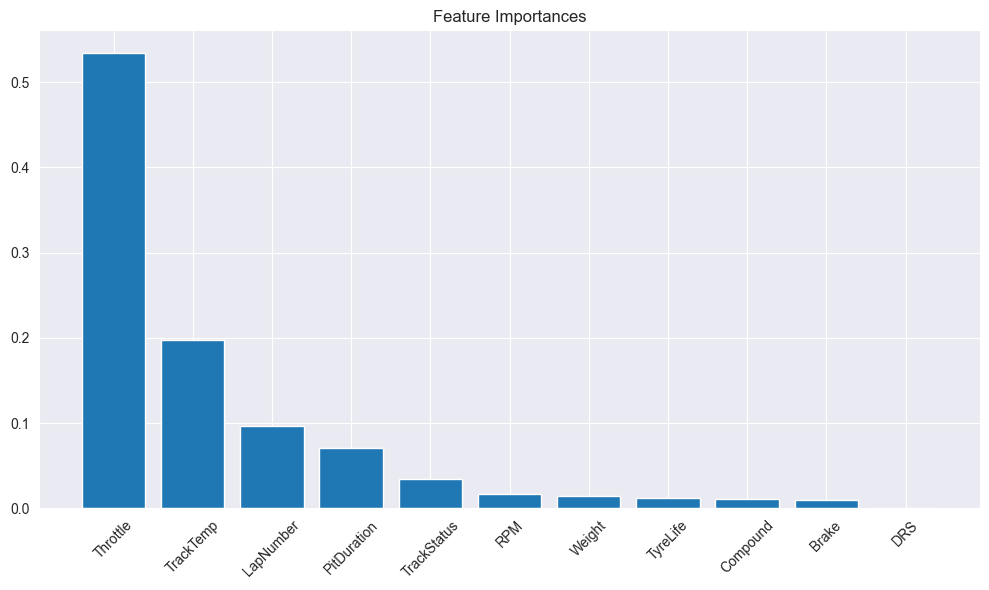

In [8]:
plot_feature_importances(model, X.columns)